#### Read the raw text.

In [1]:
directory = 'brown-europarl'
filename = 'brown-europarl'
is_text_already_split_on_sentences = True
with open('corpora/{}/{}.txt'.format(directory, filename), 'r') as fd:
    text = fd.read()

#### Determine whether or not to break the word window on sentence endings.

In [2]:
do_break_context_window_on_sentences = True

#### Convert the raw text into sentences and tokens.

In [3]:
import re
# Remove punctuation, special characters.
# TODO: !!! Keep apostrophe (') when in the middle of a word.
text = re.sub('[\',-=;:"#+<>%$_()&*@^\[\]`~{}|\\\\]+', ' ', text)
# Create sentences, or boundaries for our context window.
if do_break_context_window_on_sentences:
    if is_text_already_split_on_sentences:
        # The text is split on sentence endings.
        text = re.sub('[.?!]+', ' ', text)
    else:
        # Create sentence endings in a naive way.
        text = re.sub('[.?!]+', '\n', text)
    sentences = text.split('\n')
else:
    # Treat the entire text as a single sentence.
    text = re.sub('[.?!]+', ' ', text)
    sentences = [text]
# TODO: Do we have to convert all of the text to lowercase?
token_sentences = [[token.lower() for token in sentence.strip().split()] for sentence in sentences]
print("Sentences: {}".format(len(token_sentences)))
token_count = len(token_sentences[0])
vocab = set(token_sentences[0])
for sentence in token_sentences[1:]:
    token_count += len(sentence)
    vocab.update(sentence)
print("Tokens: {}".format(token_count))
vocab = list(vocab)
vocab.sort()
m = len(vocab)
print("Vocabulary terms: {}".format(m))

Sentences: 1454162
Tokens: 36798238
Vocabulary terms: 83177


#### Write the vocabulary to a file.

In [4]:
with open('corpora/{}/{}.vocab'.format(directory, filename), 'w') as fd_vocab:
    for i in range(m):
        fd_vocab.write("{}\n".format(vocab[i]))

#### Avoid using `vocab.index(word)` since it runs in O(n); instead, create a dictionary to look up word indices.

In [5]:
lookup = {}
for i, v in enumerate(vocab):
    lookup[v] = i
lookup['the']

73729

#### Create the co-occurrence matrix.

In [6]:
import numpy as np
# r = Window radius: Terms to the left or right of a
#  given term defined as being in the same "context".
r = 8
co = [dict() for _ in range(m)]
def occur(co, token, other):
    """Update the co-occurrence matrix when a word appears in another word's context."""
    i = lookup[token]
    try:
        co[i][other] += 1
    except KeyError:
        co[i][other] = 1

for sentence in token_sentences:
    for t, token in enumerate(sentence):
        # Count co-occurrences to the left of this term.
        for other in sentence[max(0, t - r):t]:
            occur(co, token, other)
        # Count co-occurrences to the right of this term.
        for other in sentence[t + 1:min(t + 1 + r, len(sentence))]:
            occur(co, token, other)

## Gradient Descent - _this is the slowest part!_

In [17]:
vector_dim = 200
iterations = 25
co_max = max([max([0]+list(d.values())) for d in co])
weight_alpha = 3/4
learning_rate = .01
co_max

2492110

In [18]:
center_embedding = np.random.uniform(low=-1, high=1, size=(m, vector_dim))
context_embedding = np.random.uniform(low=-1, high=1, size=(m, vector_dim))

center_bias = np.random.uniform(low=-1, high=1, size=(m))
context_bias = np.random.uniform(low=-1, high=1, size=(m))

##### Variable update historical arrays
center_history = np.zeros((m, vector_dim)) + .1
context_history = np.zeros((m, vector_dim)) + .1
bias_center_history = np.zeros(m) + .1
bias_context_history = np.zeros(m) + .1

def weight_fun(x, co_max, alpha):
    if x >= co_max:
        return 1
    return np.power(x/co_max, alpha)

losses = []
for iters in range(iterations):
    global_loss = 0
    for i in range(m):
        for other in co[i]:
            j = lookup[other]
            count = co[i][other]
            
            center = center_embedding[i,:]
            context = context_embedding[j,:]
            b1 = center_bias[i]
            b2 = context_bias[j]
            weight = weight_fun(count, co_max, weight_alpha)
            inner_loss = np.dot(center, context) + b1 + b2 - np.log(count)
            loss = weight * np.square(inner_loss)
            global_loss += loss

            ### Compute Gradients
            grad_center = weight * inner_loss * context
            grad_context = weight * inner_loss * center
            grad_bias_center = weight * inner_loss
            grad_bias_context = weight * inner_loss

            center_embedding[i,:] -=  learning_rate * (grad_center  / np.sqrt(center_history[i,:]))
            context_embedding[j,:] -= learning_rate * (grad_context / np.sqrt(context_history[j,:]))
            center_bias[i] -=  learning_rate * (grad_bias_center / np.sqrt(bias_center_history[i]))
            context_bias[j] -= learning_rate * (grad_bias_context / np.sqrt(bias_context_history[j]))

            center_history[i,:] += np.square(grad_center)
            context_history[j,:] += np.square(grad_context)
            bias_center_history[i] += np.square(grad_bias_center)
            bias_context_history[j] += np.square(grad_bias_context)
    losses.append(global_loss)
    print("Completed iteration: {}".format(iters))

Completed iteration: 0
Completed iteration: 1
Completed iteration: 2
Completed iteration: 3
Completed iteration: 4
Completed iteration: 5
Completed iteration: 6
Completed iteration: 7
Completed iteration: 8
Completed iteration: 9
Completed iteration: 10
Completed iteration: 11
Completed iteration: 12
Completed iteration: 13
Completed iteration: 14
Completed iteration: 15
Completed iteration: 16
Completed iteration: 17
Completed iteration: 18
Completed iteration: 19
Completed iteration: 20
Completed iteration: 21
Completed iteration: 22
Completed iteration: 23
Completed iteration: 24


#### Write the embeddings.

In [19]:
with open("corpora/{}/{}_{}_{}_{}.center".format(directory, filename, r, vector_dim, iterations), "w") as fd_center:
    for i in range(m):
        for j in range(vector_dim):
            fd_center.write("{} ".format(center_embedding[i][j]))
        # Write the bias weight.
        fd_center.write("{}\n".format(center_bias[i]))

In [20]:
with open("corpora/{}/{}_{}_{}_{}.context".format(directory, filename, r, vector_dim, iterations), "w") as fd_context:
    for i in range(m):
        for j in range(vector_dim):
            fd_context.write("{} ".format(context_embedding[i][j]))
        # Write the bias weight.
        fd_context.write("{}\n".format(context_bias[i]))

#### Show the loss.

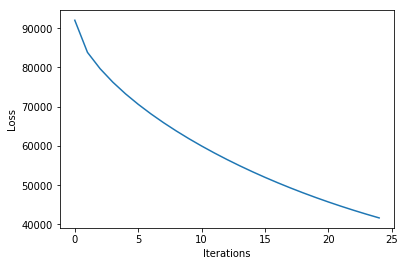

In [21]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

#### Write the global losses.

In [22]:
with open("corpora/{}/{}_{}_{}_{}.loss".format(directory, filename, r, vector_dim, iterations), "w") as fd_loss:
    for loss in losses:
        fd_loss.write("{}\n".format(loss))